In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# from matplotlib import pylab as plt
import lsst.afw.display.rgb as rgb

In [2]:
import os
import imp
import numpy as np
import pickle
import galsim
from lsst.afw.geom import Angle
from lsst.sims.photUtils import matchStar

imp.load_source('calc_refractive_index', '/Users/sullivan/LSST/code/StarFast/calc_refractive_index.py')
imp.load_source('fast_dft', '/Users/sullivan/LSST/code/StarFast/fast_dft.py')
imp.load_source('StarFast', '/Users/sullivan/LSST/code/StarFast/StarFast.py')
from StarFast import StarSim

lsst_lat = Angle(np.radians(-30.244639))
lsst_lon = Angle(np.radians(-70.749417))
lsst_alt = 2663.
filter_name = 'g'

In [3]:
from lsst.sims.photUtils import PhotometricParameters, Bandpass, Sed
from lsst.utils import getPackageDir

In [4]:
def look(img, range=None, x_range=None, y_range=None, large=False,outfile=None):
    """Simple function to wrap matplotlib and display an image with a colorbar."""
    if large:
        plt.figure(figsize=(32, 12))
    else:
        plt.figure(figsize=(16, 6))
    if range is None:
        range = [np.min(img), np.max(img)]
#     img_use = np.clip(img, range[0], range[1])
    img_use = img.copy()
    if x_range is not None:
        x0 = int(x_range[0])
        x1 = int(x_range[1])
        if x0 < 0:
            img_use = np.roll(img_use, -x0, axis=1)
            x1 -= x0
            x0 = 0
        img_use = img_use[:, x0: x1]
    if y_range is not None:
        y0 = int(y_range[0])
        y1 = int(y_range[1])
        if y0 < 0:
            img_use = np.roll(img_use, -y0, axis=0)
            y1 -= y0
            y0 = 0
        img_use = img_use[y0: y1, :]
#     if preserve_scale:
#         img_use[0,0] = range[0]
#         img_use[-1,-1] = range[1]
    fig_show = plt.imshow(img_use, interpolation='none', origin='lower', cmap=cm.rainbow, clim=range)
    plt.colorbar(fig_show, orientation='vertical', shrink=1)
    if outfile is not None:
        plt.savefig(outfile)
#    cbar.set_label('DCR (arcsec)', labelpad=0)
    plt.show()

Set up the general parameters to use for all of the simulations 

In [5]:
seed = 6  # Seed for the random number generator. Simulations with the same seed are reproduceable
dimension = 1024  # Number of pixels on a side for the simulated image
n_star = 10000  # Number of stars to model in the simulated catalog.
# The catalog covers an area ~4x larger than the area, to allow simulated rotations and dithering observations
pixel_scale = 0.25  # plate scale, in arcseconds/pixel
psf_fwhm = 0.25  # FWHM of the PSF, in arcseconds
hottest_star = 'B'  # Hottest star to include (types are 'OBAFGKMR')
coolest_star = 'M'  # Coolest star to include
wavelength_step = 1  # Wavelength resolution of the spectra and calculation of filter and DCR effects. In nm.
ra_offset = Angle(0)  # Additional offset in RA from the field center, for dithering. In radians as an LSST Angle object
dec_offset = Angle(0)  # Additional offset in Dec from the field center, for dithering. In radians as an LSST Angle object
sky_rotation = 0.0  # Sky rotation angle, in Degrees. I realize this is different than RA and Dec
exposureId = 0  # Unique exposure identification number. Also used as the "OBSID"
instrument_noise = 0.  # Adds noise akin to instrumental noise (post-PSF). Set to 1.0 for default value, can be scaled up or down
photon_noise = 1./15.  # Adds poisson noise akin to photon shot noise. Set to 1.0 for default value, can be scaled up or down
sky_noise = 0  # Adds noise prior to convolving with the PSF.
elevation_min = 30.0  # Minimum observation elevation angle to simulate, in degrees
elevation_max = 90.0  # Open maximum observation angle, in degrees. Only anlges less than elevation_max will be simulated
elevation_step = 5  # Elevation angle step size, in degrees.
output_directory = "/Users/sullivan/LSST/simulations/test%1i_new/" % seed  # Path to the directory to save output
band_dict = {'u': 0, 'g': 1, 'r': 2, 'i': 3, 'z': 4, 'y': 5}  # LSST filter numbers used by the butler

In [6]:
attenuation = 20. # attenuation factor that was used in the simulations

In [7]:
ra = lsst_lon + ra_offset
dec = lsst_lat + dec_offset

Load simulated Kurucz stellar SEDs. Cache the list for later use.

In [8]:
pickle_file = "sed_list.pickle"
if os.path.exists(pickle_file):
    with open(pickle_file, 'rb') as dumpfile:
        sed_list = pickle.load(dumpfile)
else:
    matchStarObj = matchStar()
    sed_list = matchStarObj.loadKuruczSEDs()
    with open(pickle_file, 'wb') as dumpfile:
        pickle.dump(sed_list, dumpfile)

Set up the PSF.

In [9]:
gsp = galsim.GSParams(folding_threshold=1.0 / (dimension), maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=psf_fwhm / pixel_scale, flux=1, gsparams=gsp)

In [10]:
band_name = 'g'

In [11]:
use_bp = True
sim = StarSim(psf=psf, pixel_scale=pixel_scale, x_size=dimension, y_size=dimension,
              band_name=band_name, wavelength_step=wavelength_step,
              sed_list=sed_list, ra=ra, dec=dec, sky_rotation=sky_rotation,
              use_mirror=use_bp, use_lens=use_bp, use_atmos=use_bp,
              use_filter=use_bp, use_detector=use_bp, attenuation=attenuation)

Simulate a catalog of stars, with fluxes and SEDs

In [12]:
sim.load_catalog(n_star=n_star, hottest_star=hottest_star, coolest_star=coolest_star, seed=seed)

Number and flux contribution of stars of each type:
 [M 7594| 1.54%] [K 1247| 2.14%] [G 788| 3.47%] [F 286| 4.12%] [A 73| 13.12%] [B 12| 75.61%] [O 0| 0.00%]


In [13]:
sim.star_flux.shape

(2483, 147)

In [14]:
sim.coord.pad = 1

In [15]:
from StarFast import _wavelength_iterator

In [16]:
sim_wl = [wl for wl in _wavelength_iterator(sim.bandpass, use_midpoint=True)]

Load measurements from the DCR model

In [17]:
repository = '/Users/sullivan/LSST/simulations/test6_new/output_data/'
obsid_range = np.arange(106, 124, 3)
band_name = "g"

In [18]:
from python.buildDcrCoadd import BuildDcrCoadd
from python.generateTemplate import GenerateTemplate

In [28]:
self = BuildDcrCoadd(n_step=5, input_repository=repository, obsids=obsid_range, filter_name=band_name)

In [40]:
sim_photParams = sim.photParams
meas_photParams = PhotometricParameters(exptime=self.exposure_time, nexp=1,
                                        platescale=self.pixel_scale, bandpass=self.filter_name)

output_directory='/Users/sullivan/LSST/simulations/test5/output_data/'

self.load_model(model_repository=output_directory)

In [41]:
meas_wl = [wl for wl in self._wavelength_iterator(self.bandpass, use_midpoint=True)]

Load the measurements from forced photometry

In [22]:
import lsst.daf.persistence as daf_persistence
butler_Cat = daf_persistence.Butler("/Users/sullivan/LSST/simulations/test6_new/task_test_5sub/")

In [42]:
meas_src = [butler_Cat.get("dcrCoadd_meas",dataId={'tract':0,'patch':'0,0','filter':'g','subfilter':_s})
            for _s in range(self.n_step)]

Match sources between the simulations and measurements

In [43]:
# import zip
def src_match(sx, sy, cat, err_match, verbose=True):
    cat_x = cat.getX()
    cat_y = cat.getY()
    ind_match = {}
    i = -1
    i2 = 0
    for _x, _y in zip(sx, sy):
        i += 1
        dist = np.sqrt((_x - cat_x)**2. + (_y - cat_y)**2.)
        match_test = dist < err_match
        n_match = np.sum(match_test)
        if n_match == 1:
            ind_match[i] = np.where(match_test)[0][0]
            i2+=1
        elif n_match > 1:
            if verbose:
                print("Multiple matches")
    print("Matched: %i, Unmatched: %i" % (i2, i - i2))
    return(ind_match)

In [44]:
matches = src_match(sim.coord.x_loc(), sim.coord.y_loc(), meas_src[0], 1, verbose=False)

Matched: 413, Unmatched: 2053


In [45]:
print(sim_wl[1] - sim_wl[0])
print(meas_wl[1] - meas_wl[0])

0.999235703403
25.2182155608


In [46]:
wavestep_sim = sim.bandpass.wavelen_step
wavestep_meas = self.bandpass.wavelen_step
ratio_meas_sim = wavestep_meas/wavestep_sim

In [47]:
sim_delta = sim.bandpass.wavelen_step
meas_delta = self.bandpass.wavelen_step

In [48]:
def convert_flux(flux_in, wl_in, bp_out):
    wl_iter = _wavelength_iterator(bp_out, use_midpoint=False)
    flux_out = []
    for wl_start, wl_end in wl_iter:
        wl_use = (wl_in >= wl_start) & (wl_in < wl_end)
        flux = np.sum(flux_in[wl_use])
        flux_out.append(flux)
    return np.array(flux_out)

In [49]:
def extract_temperature(self):
    CoordsXY = self.coord
    xv_full = self.catalog.getX()
    yv_full = self.catalog.getY()

    # The catalog may include stars outside of the field of view of this observation, so trim those.
    xmin = self.edge_dist
    xmax = CoordsXY.xsize(base=True) - self.edge_dist
    ymin = self.edge_dist
    ymax = CoordsXY.ysize(base=True) - self.edge_dist
    include_flag = ((xv_full >= xmin) & (xv_full < xmax) & (yv_full >= ymin) & (yv_full < ymax))
    temps = [self.catalog[ii]["temperature"] for ii in range(len(self.catalog)) if include_flag[ii]]
    return temps

In [50]:
cat_temps = extract_temperature(sim)

In [51]:
def plt_spectrum(ind):
    i0 = list(matches.keys())[ind]
    i1 = matches[i0]
    sim_flux = convert_flux(sim.star_flux[i0,:], np.array(sim_wl), self.bandpass)
    meas_flux = np.array([src.getPsfFlux()[i1] for src in meas_src])
    print("Temperature: %fK" % cat_temps[i0])
    print(sim_flux)
    print(meas_flux)
    plt.plot(sim_wl, sim.star_flux[i0,:]*ratio_meas_sim)
    plt.plot(meas_wl, meas_flux, 'g+')

In [52]:
cat_temps_use = np.array([cat_temps[ii] for ii in list(matches.keys())])
temp_6K = (cat_temps_use > 6000)*(cat_temps_use < 7000)

In [53]:
np.where(temp_6K)

(array([372, 374, 375, 377, 378, 380, 381, 382, 383, 384, 385, 386, 387,
        388, 389, 391, 392, 393, 394, 395, 396, 397, 398, 401, 402, 403, 406]),)

Temperature: 7161.991460K
[ 3852.41569562  5427.1715229   5611.17958697  5901.77556948  4973.53217456
     0.        ]
[ 4090.78996532  5434.66230827  5941.56866098  6031.46068009  5347.14439364]


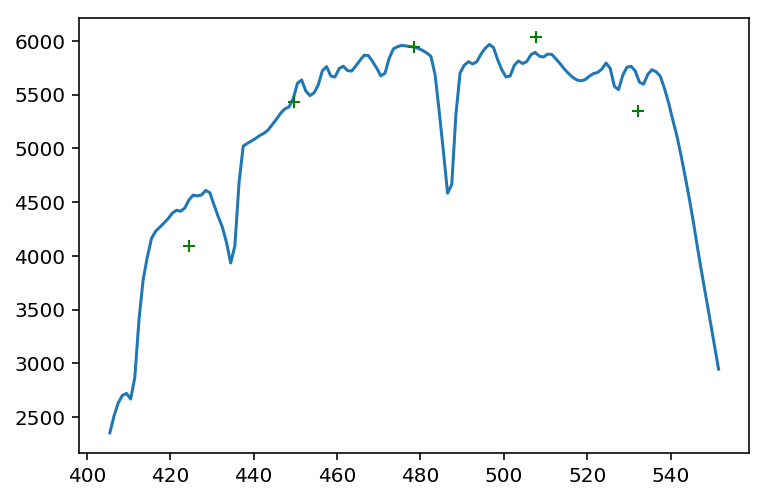

In [54]:
plt_spectrum(399)

Temperature: 4080.264117K
[  96.11452495  215.33046528  327.96882407  452.05211593  485.01767857
    0.        ]
[ 137.37006714  254.47365206  343.74833246  404.55171984  401.89526704]


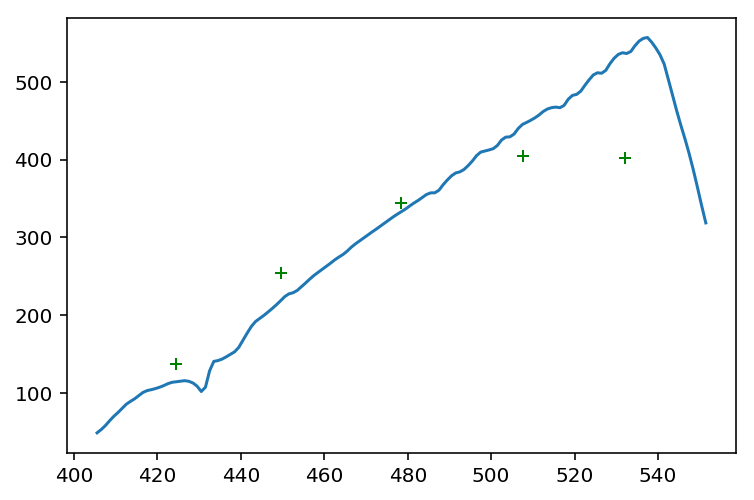

In [55]:
plt_spectrum(200)

Temperature: 4517.485675K
[ 129.65585436  262.24200584  369.21067838  460.33963844  460.39531855
    0.        ]
[ 164.31780715  282.1140354   362.12042671  407.85143756  390.10352894]


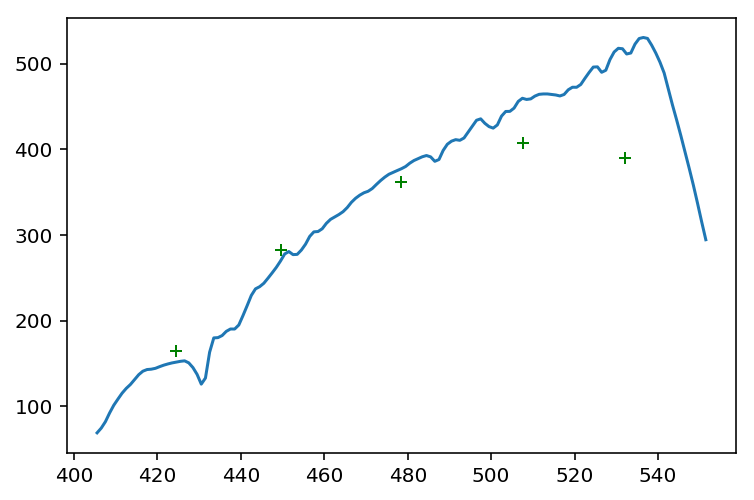

In [56]:
plt_spectrum(18)

Temperature: 4941.466375K
[  803.35537723  1623.34906459  2231.47610497  2599.88325336  2517.20466498
     0.        ]
[ 1011.05671658  1690.04611843  2134.76978908  2389.19458278  2284.72313814]


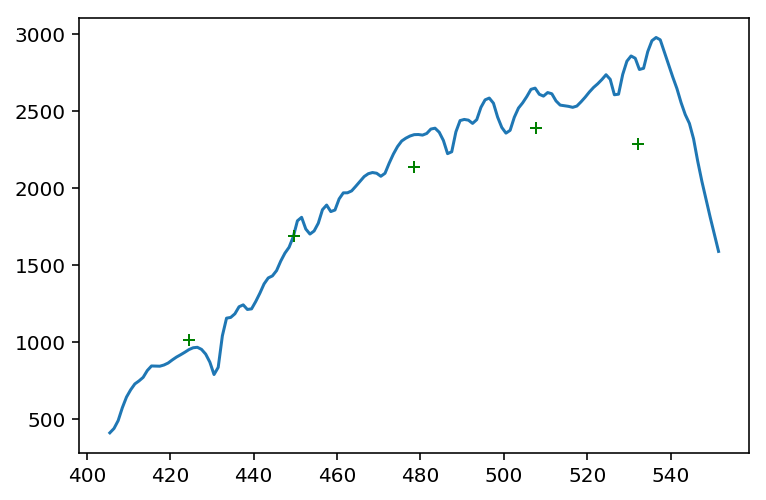

In [57]:
plt_spectrum(100)

Temperature: 6689.247989K
[ 2806.66210203  3766.81498386  3823.30311428  4036.22770048  3378.28046203
     0.        ]
[ 2711.19951872  3535.07041522  3824.12109783  3863.78213559  3415.42048634]


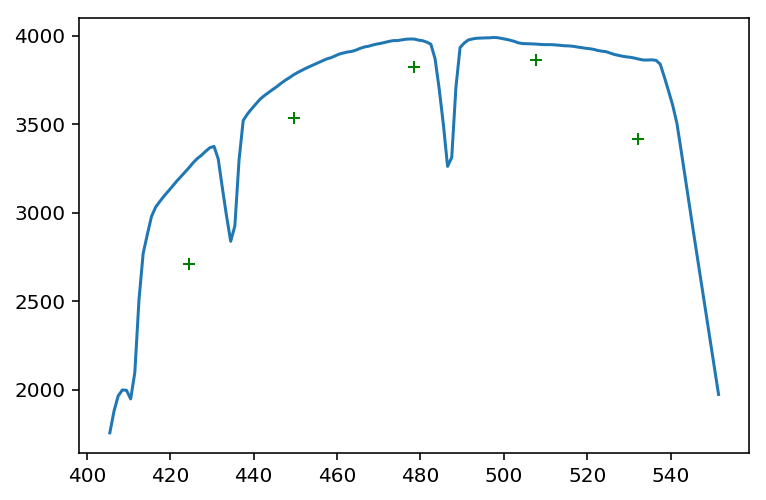

In [58]:
plt_spectrum(398)

Make new bandpasses for each DCR sub-band

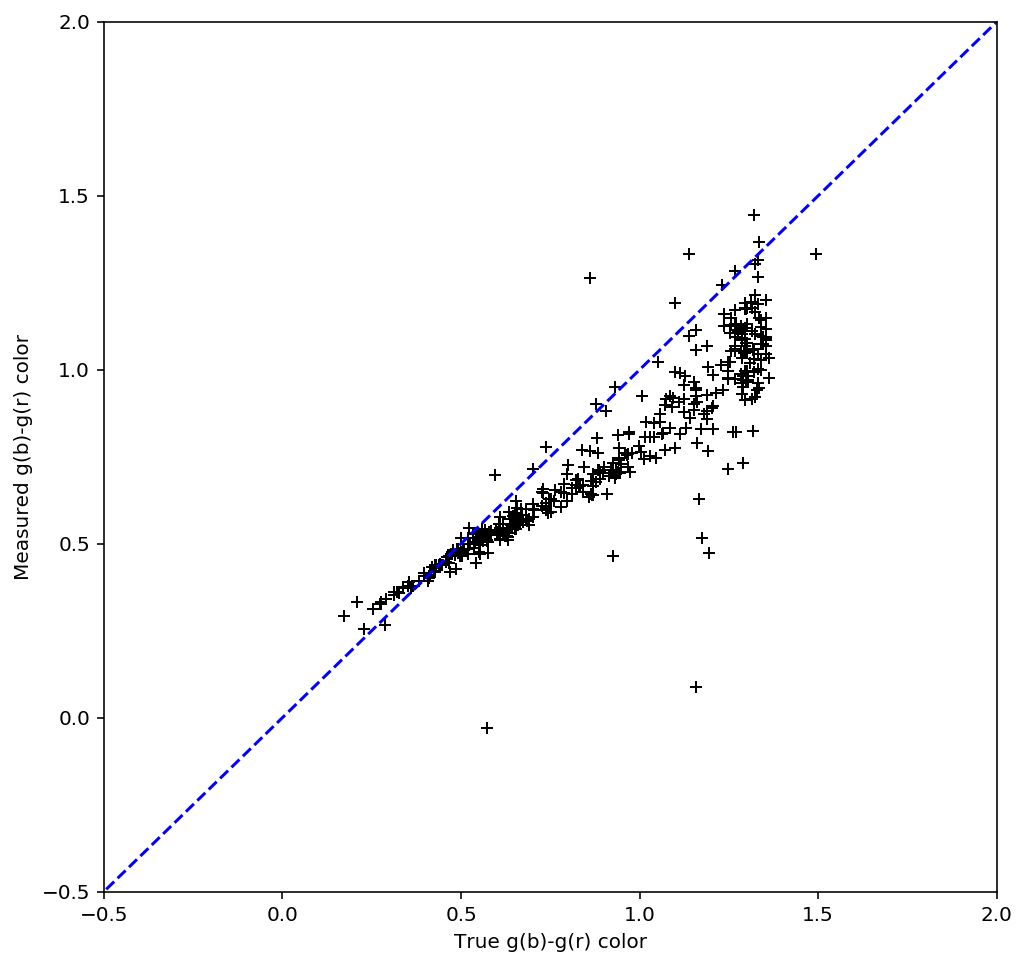

In [59]:
meas_color = []
sim_color = []

for key in list(matches.keys()):
    i0 = key
    i1 = matches[i0]
    sim_flux = convert_flux(sim.star_flux[i0,:], np.array(sim_wl), self.bandpass)
    meas_flux = np.array([src.getPsfFlux()[i1] for src in meas_src])
    meas_mag0 = -2.512 * np.log10(meas_flux[0])
    meas_mag1 = -2.512 * np.log10(meas_flux[2])
    sim_mag0 = -2.512 * np.log10(sim_flux[0])
    sim_mag1 = -2.512 * np.log10(sim_flux[2])
    meas_color.append(meas_mag0 - meas_mag1)
    sim_color.append(sim_mag0 - sim_mag1)
fig=plt.figure(figsize=(8,8))
plot_1 = fig.add_subplot(1,1,1)
plot_1.plot(np.array(sim_color), (np.array(meas_color)), 'k+')
plot_1.plot([-1, 2], [-1, 2], linestyle='--', color='b')
plot_1.set_xlim([-.5, 2])
plot_1.set_ylim([-.5, 2])
plot_1.set_ylabel('Measured g(b)-g(r) color')
plot_1.set_xlabel('True g(b)-g(r) color')

In [60]:
def resistant_fit(x, y, degree=1):
    median_slope = np.median(y/x)
    median_offset = np.median(y - median_slope*x)
    delta = y - (median_slope*x + median_offset)
    sigma = np.std(delta)
    i_use = np.abs(delta) < 3.*sigma
    fit_params = np.polyfit(x[i_use], y[i_use], degree)
    return fit_params

# Full bandpass flux

0.963128464295


[]

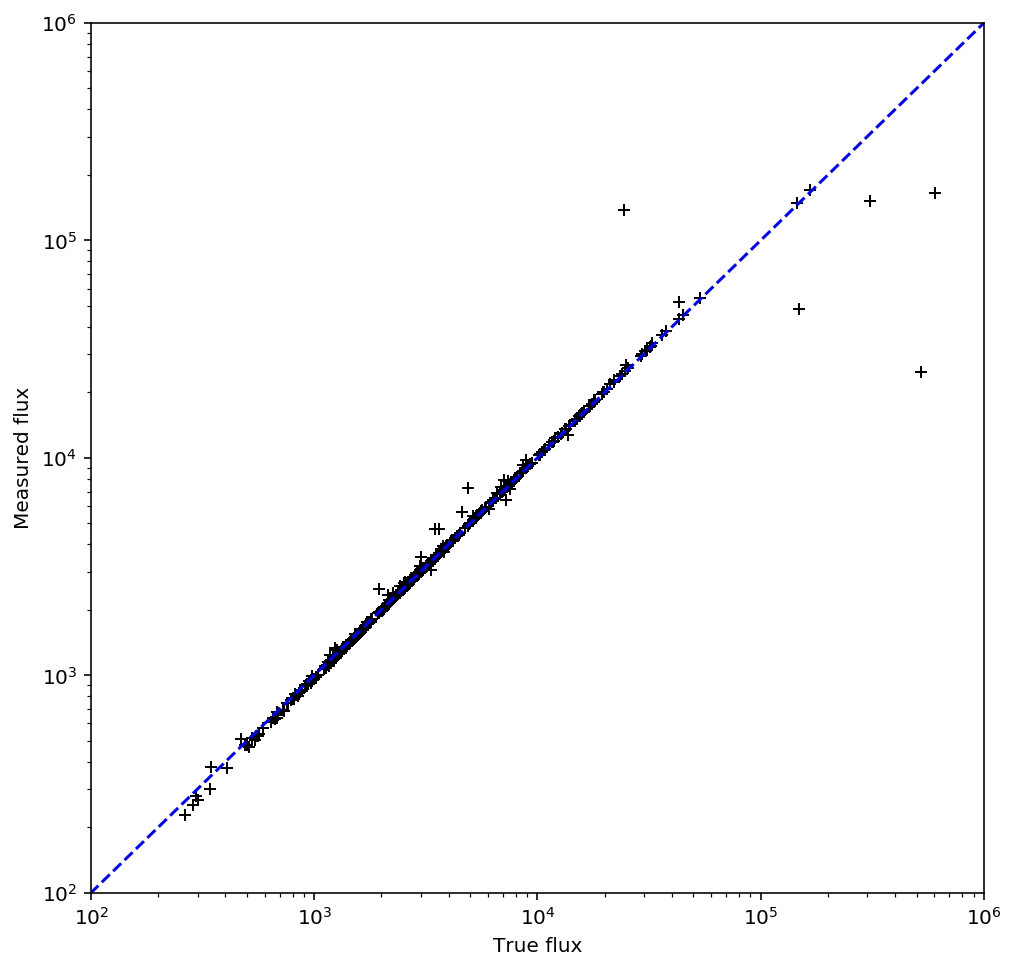

In [61]:
meas_flux = []
sim_flux = []

for key in list(matches.keys()):
    i0 = key
    i1 = matches[i0]
#     bandpass_use = bandpass
#     sim_sed = create_sed(sim_wl, fnu=sim.star_flux[i0,:])      
    meas_flux_single = np.sum([src.getPsfFlux()[i1] for src in meas_src])
    meas_flux.append(meas_flux_single)
    sim_flux_single = np.sum(sim.star_flux[i0,:])
    sim_flux.append(sim_flux_single)
meas_flux = np.array(meas_flux)
sim_flux = np.array(sim_flux)
scale = np.median(meas_flux/sim_flux)
print(scale)
fig=plt.figure(figsize=(8,8))
plot_1 = fig.add_subplot(1,1,1)
plot_1.plot(sim_flux*scale, meas_flux, 'k+')
plot_1.plot([1e-6, 2e6], [1e-6, 2e6], linestyle='--', color='b')
plot_1.set_xlim([100, 1e6])
plot_1.set_ylim([100, 1e6])
plot_1.set_ylabel('Measured flux')
plot_1.set_xlabel('True flux')
plot_1.loglog()

In [38]:
subband_ratio = np.zeros(3)
subband_offset = np.zeros(3)
subband_slope = np.zeros(3)

# Blue bandpass flux

0.955242046216
[   0.70935946  336.23429312]


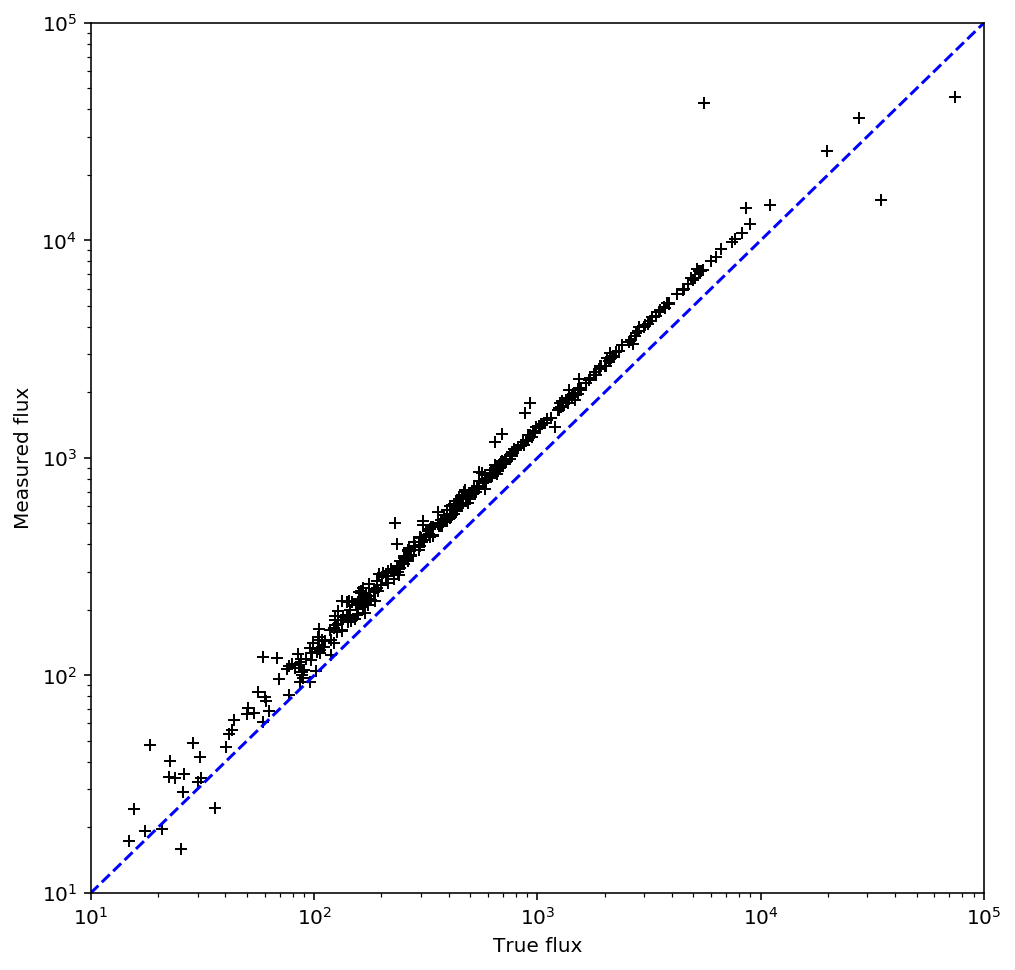

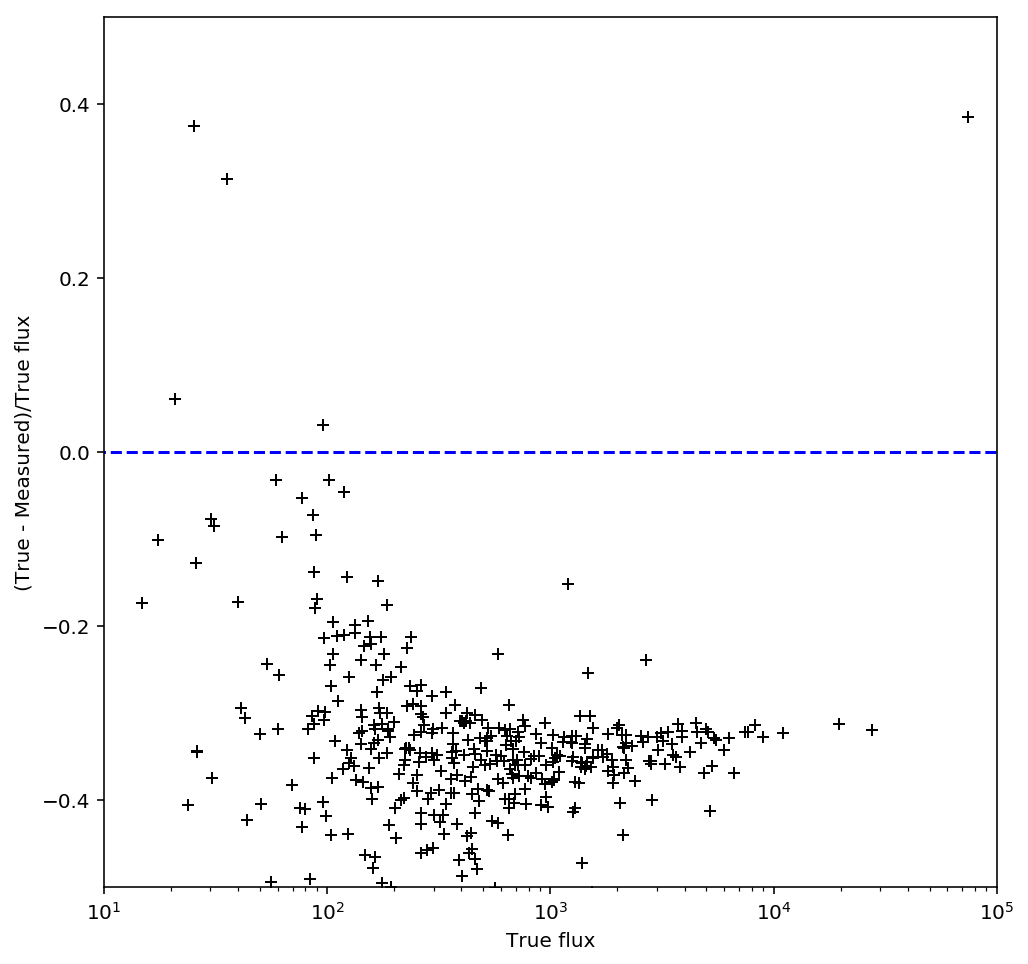

In [52]:
meas_flux = []
sim_flux = []

scale = 1.
bp_id = 0
for key in list(matches.keys()):
    i0 = key
    i1 = matches[i0]
#     bandpass_use = bandpasses[bp_id]
    meas_flux_single = [src.getPsfFlux()[i1] for src in meas_src]
    meas_flux.append(meas_flux_single[bp_id])
    sim_flux_single = convert_flux(sim.star_flux[i0,:], np.array(sim_wl), self.bandpass)
    sim_flux.append(sim_flux_single[bp_id])
meas_flux = np.array(meas_flux)
sim_flux = np.array(sim_flux)
scale = np.median(meas_flux/sim_flux)
subband_ratio[bp_id] = scale
print(scale)
linear_fit = resistant_fit(x=sim_flux, y=meas_flux, degree=1)
print(linear_fit)
subband_slope[bp_id] = linear_fit[0]
subband_offset[bp_id] = linear_fit[1]
sim_fit = sim_flux*linear_fit[0] #+ linear_fit[1]
fig=plt.figure(figsize=(8,8))
plot_1 = fig.add_subplot(1,1,1)
plot_1.plot(sim_fit, meas_flux, 'k+')
plot_1.plot([1e-6, 2e6], [1e-6, 2e6], linestyle='--', color='b')
plot_1.set_xlim([10, 1e5])
plot_1.set_ylim([10, 1e5])
plot_1.set_ylabel('Measured flux')
plot_1.set_xlabel('True flux')
plot_1.loglog()

fig=plt.figure(figsize=(8,8))
plot_2 = fig.add_subplot(1,1,1)
plot_2.plot(sim_fit, (sim_fit - meas_flux)/sim_fit, 'k+')
plot_2.plot([1e-6, 2e6], [0, 0], linestyle='--', color='b')
plot_2.set_xlim([10, 1e5])
plot_2.set_ylim([-.5,.5])
plt.xscale('log')
plot_2.set_ylabel('(True - Measured)/True flux')
plot_2.set_xlabel('True flux')

# Center bandpass flux

0.988059994946
[   0.84816954  299.39977031]


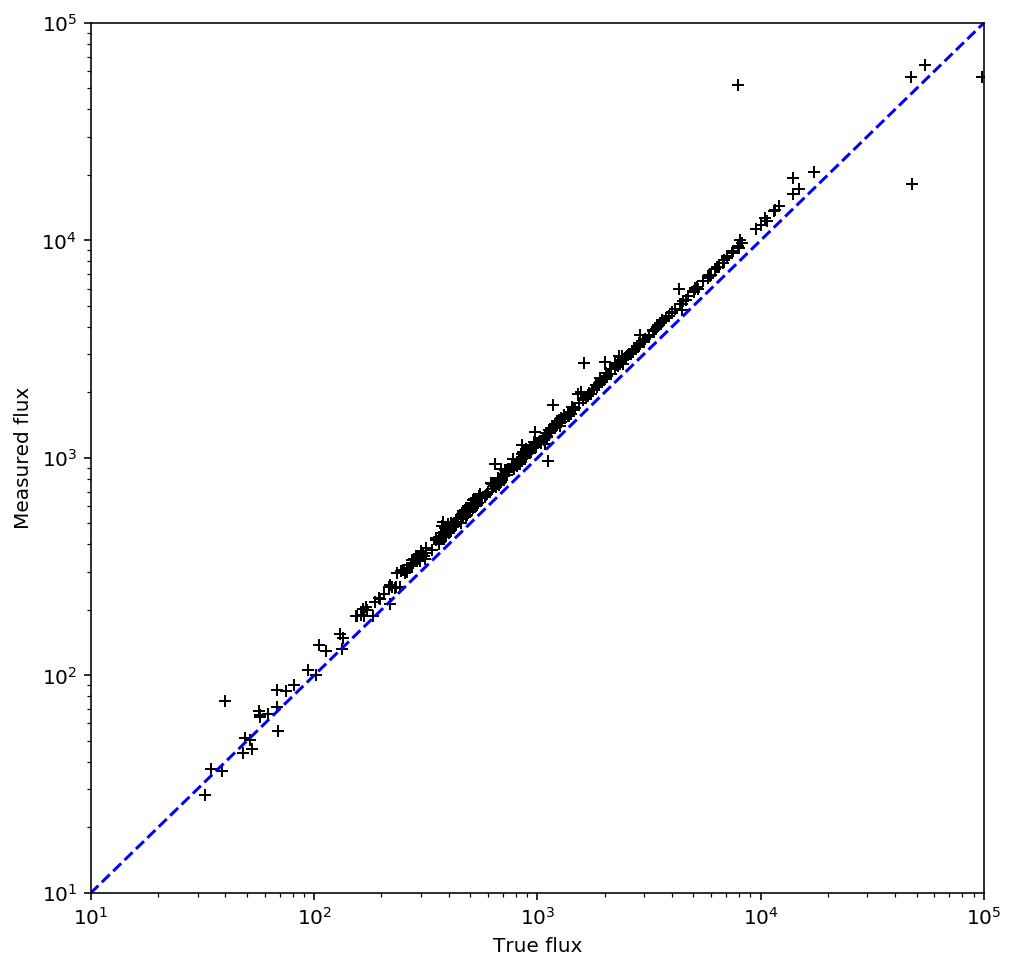

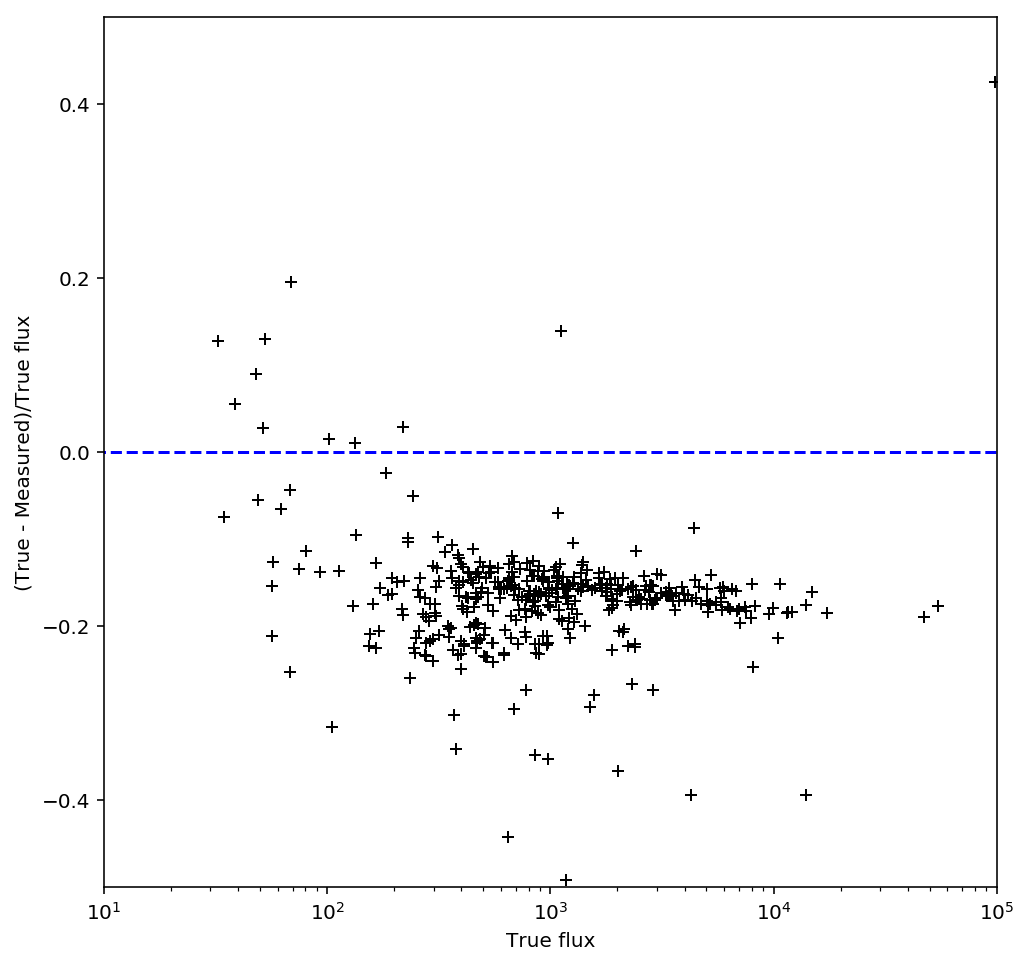

In [53]:
meas_flux = []
sim_flux = []

scale = 1.
bp_id = 1
for key in list(matches.keys()):
    i0 = key
    i1 = matches[i0]
#     bandpass_use = bandpasses[bp_id]
    meas_flux_single = [src.getPsfFlux()[i1] for src in meas_src]
    meas_flux.append(meas_flux_single[bp_id])
    sim_flux_single = convert_flux(sim.star_flux[i0,:], np.array(sim_wl), self.bandpass)
    sim_flux.append(sim_flux_single[bp_id])
meas_flux = np.array(meas_flux)
sim_flux = np.array(sim_flux)
scale = np.median(meas_flux/sim_flux)
subband_ratio[bp_id] = scale
print(scale)
linear_fit = resistant_fit(x=sim_flux, y=meas_flux, degree=1)
print(linear_fit)
subband_slope[bp_id] = linear_fit[0]
subband_offset[bp_id] = linear_fit[1]
sim_fit = sim_flux*linear_fit[0] #+ linear_fit[1]
fig=plt.figure(figsize=(8,8))
plot_1 = fig.add_subplot(1,1,1)
plot_1.plot(sim_fit, meas_flux, 'k+')
plot_1.plot([1e-6, 2e6], [1e-6, 2e6], linestyle='--', color='b')
plot_1.set_xlim([10, 1e5])
plot_1.set_ylim([10, 1e5])
plot_1.set_ylabel('Measured flux')
plot_1.set_xlabel('True flux')
plot_1.loglog()

fig=plt.figure(figsize=(8,8))
plot_2 = fig.add_subplot(1,1,1)
plot_2.plot(sim_fit, (sim_fit - meas_flux)/sim_fit, 'k+')
plot_2.plot([1e-6, 2e6], [0, 0], linestyle='--', color='b')
plot_2.set_xlim([10, 1e5])
plot_2.set_ylim([-.5,.5])
plt.xscale('log')
plot_2.set_ylabel('(True - Measured)/True flux')
plot_2.set_xlabel('True flux')

# Red bandpass flux

0.978760994092
[  0.98368352  17.31624898]


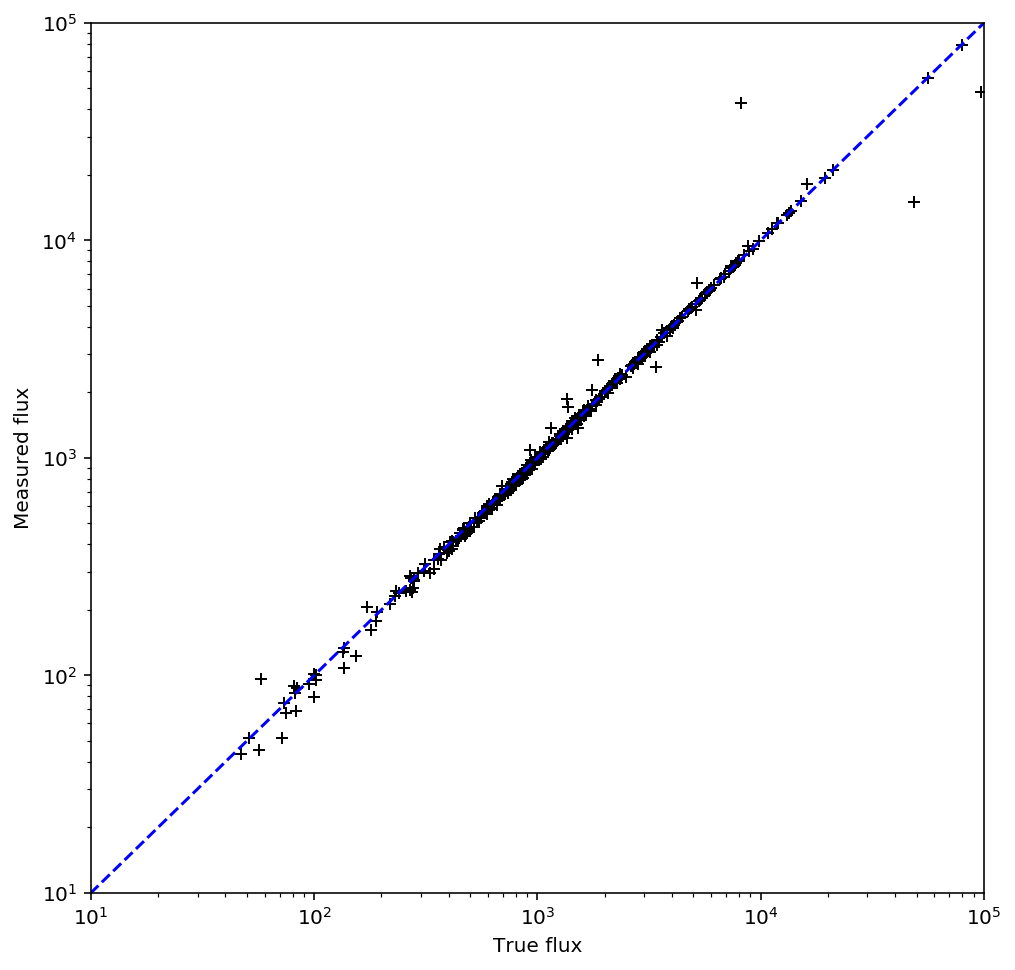

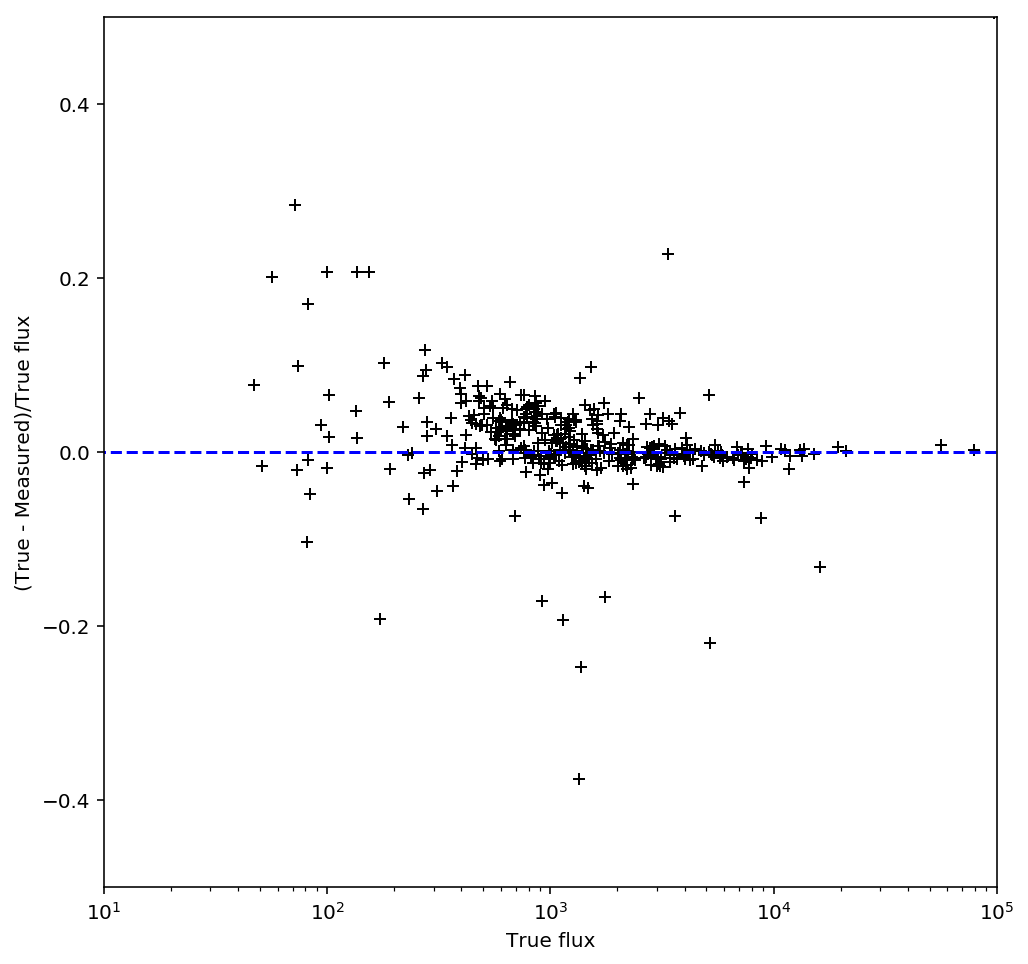

In [54]:
meas_flux = []
sim_flux = []

scale = 1.
bp_id = 2
for key in list(matches.keys()):
    i0 = key
    i1 = matches[i0]
#     bandpass_use = bandpasses[bp_id]
    meas_flux_single = [src.getPsfFlux()[i1] for src in meas_src]
    meas_flux.append(meas_flux_single[bp_id])
    sim_flux_single = convert_flux(sim.star_flux[i0,:], np.array(sim_wl), self.bandpass)
    sim_flux.append(sim_flux_single[bp_id])
meas_flux = np.array(meas_flux)
sim_flux = np.array(sim_flux)
scale = np.median(meas_flux/sim_flux)
print(scale)
subband_ratio[bp_id] = scale
linear_fit = resistant_fit(x=sim_flux, y=meas_flux, degree=1)
print(linear_fit)
subband_slope[bp_id] = linear_fit[0]
subband_offset[bp_id] = linear_fit[1]
sim_fit = sim_flux*linear_fit[0] #+ linear_fit[1]
fig=plt.figure(figsize=(8,8))
plot_1 = fig.add_subplot(1,1,1)
plot_1.plot(sim_fit, meas_flux, 'k+')
plot_1.plot([1e-6, 2e6], [1e-6, 2e6], linestyle='--', color='b')
plot_1.set_xlim([10, 1e5])
plot_1.set_ylim([10, 1e5])
plot_1.set_ylabel('Measured flux')
plot_1.set_xlabel('True flux')
plot_1.loglog()

fig=plt.figure(figsize=(8,8))
plot_2 = fig.add_subplot(1,1,1)
plot_2.plot(sim_fit, (sim_fit - meas_flux)/sim_fit, 'k+')
plot_2.plot([1e-6, 2e6], [0, 0], linestyle='--', color='b')
plot_2.set_xlim([10, 1e5])
plot_2.set_ylim([-.5,.5])
plt.xscale('log')
plot_2.set_ylabel('(True - Measured)/True flux')
plot_2.set_xlabel('True flux')

In [42]:
subband_ratio

array([ 0.95524205,  0.98805999,  0.97876099])

In [43]:
subband_offset

array([ 336.23429312,  299.39977031,   17.31624898])

In [44]:
subband_slope

array([ 0.70935946,  0.84816954,  0.98368352])

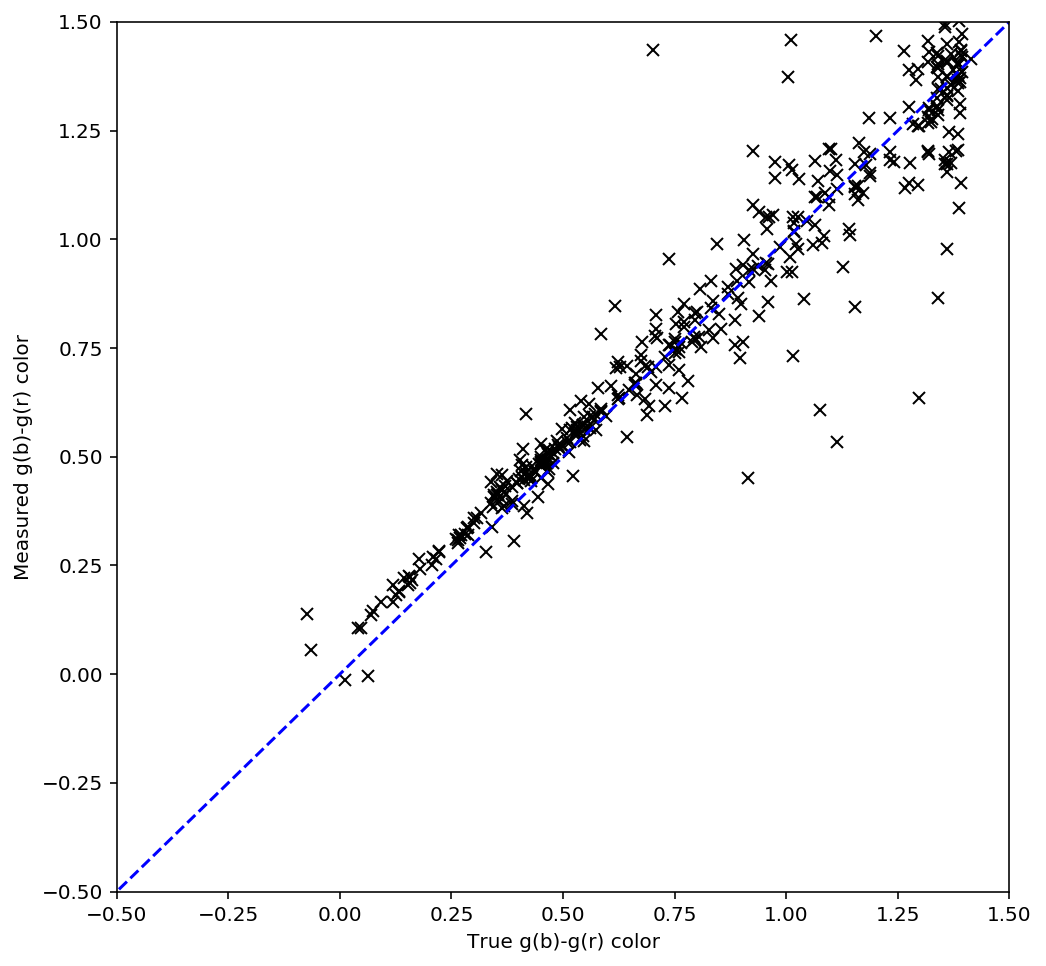

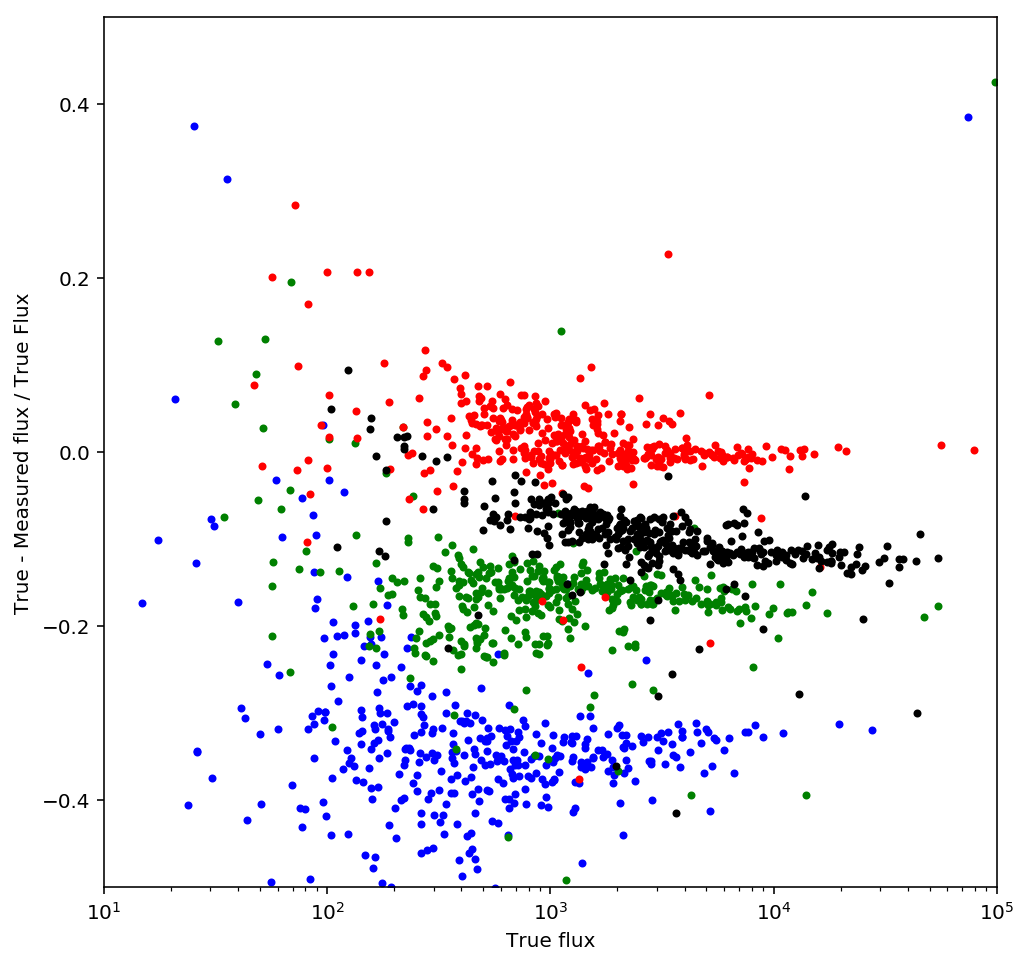

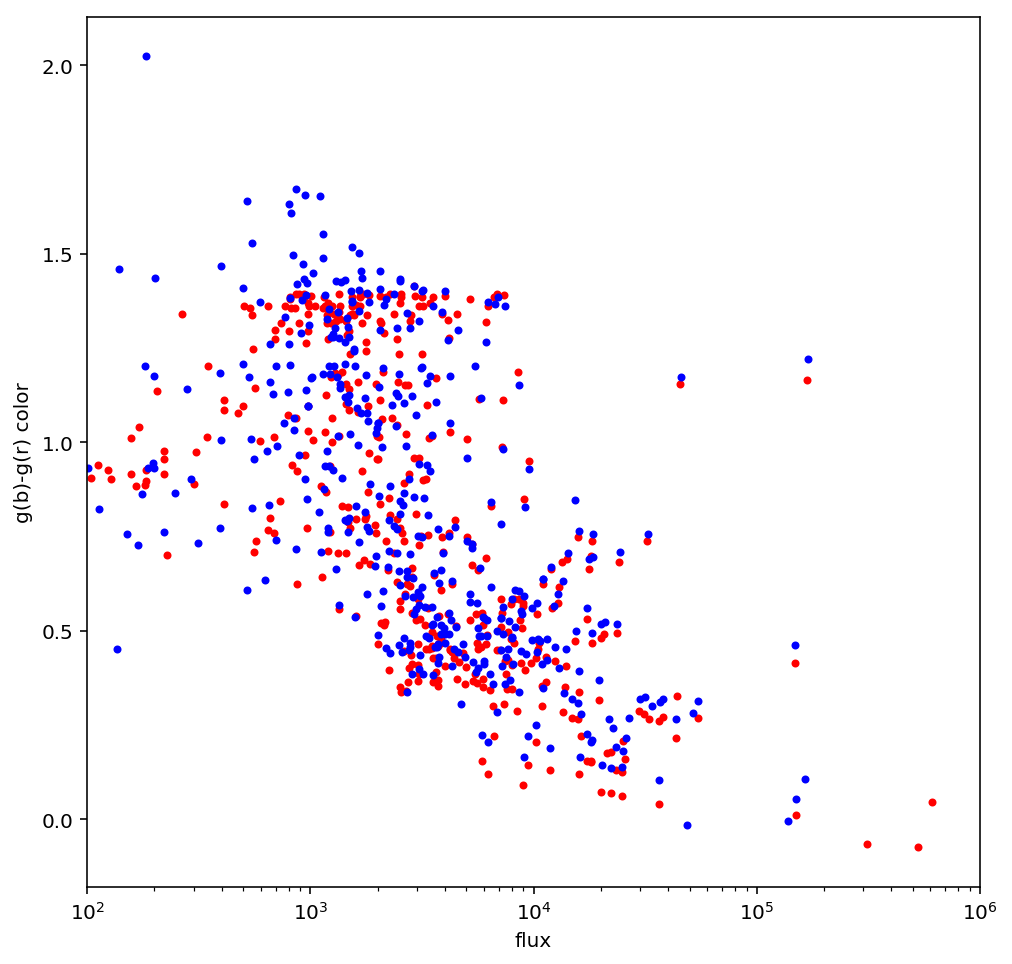

In [50]:
meas_color = []
sim_color = []

meas_flux = [[] for _s in range(self.n_step)]
sim_flux = [[] for _s in range(self.n_step)]
for key in list(matches.keys()):
    i0 = key
    i1 = matches[i0]
    sim_flux_single = convert_flux(sim.star_flux[i0,:], np.array(sim_wl), self.bandpass)
    meas_flux_single = [src.getPsfFlux()[i1] for src in meas_src]
    for ii in range(self.n_step):
        sim_flux[ii].append(sim_flux_single[ii])
        meas_flux[ii].append(meas_flux_single[ii])
meas_flux = [np.array(arr) for arr in meas_flux]
sim_flux = [np.array(arr) for arr in sim_flux]
sim_flux2 = [arr*slope for arr, slope in zip(sim_flux, subband_slope)]
sim_flux_sum = np.sum(sim_flux, axis=0)*np.mean(subband_ratio)
sim_flux2_sum = np.sum(sim_flux2, axis=0)
meas_flux_sum = np.sum(meas_flux, axis=0)
meas_color = (-2.512 * np.log10(meas_flux[0])) - (-2.512 * np.log10(meas_flux[2]))
sim_color = (-2.512 * np.log10(sim_flux[0])) - (-2.512 * np.log10(sim_flux[2]))
sim_color2 = (-2.512 * np.log10(sim_flux2[0])) - (-2.512 * np.log10(sim_flux2[2]))

# meas_color = meas_flux[0]/meas_flux[2]
# sim_color = sim_flux[0]/sim_flux[2]

fig=plt.figure(figsize=(8,8))
plot_1 = fig.add_subplot(1,1,1)
plot_1.plot(sim_color, meas_color, 'kx')
plot_1.plot([-1, 2], [-1, 2], linestyle='--', color='b')
plot_1.set_xlim([-.5, 1.5])
plot_1.set_ylim([-.5, 1.5])
plot_1.set_ylabel('Measured g(b)-g(r) color')
plot_1.set_xlabel('True g(b)-g(r) color')

fig2=plt.figure(figsize=(8,8))
plot_2 = fig2.add_subplot(1,1,1)
sim_flux_use = sim_flux2
plot_2.plot(sim_flux_use[0], (sim_flux_use[0] - meas_flux[0])/sim_flux_use[0], 'b.')
plot_2.plot(sim_flux_use[1], (sim_flux_use[1] - meas_flux[1])/sim_flux_use[1], 'g.')
plot_2.plot(sim_flux_use[2], (sim_flux_use[2] - meas_flux[2])/sim_flux_use[2], 'r.')
sim_flux2_sum = np.sum(sim_flux2, axis=0)
meas_flux_sum = np.sum(meas_flux, axis=0)
plot_2.plot(sim_flux_sum, (sim_flux2_sum - meas_flux_sum)/sim_flux_sum, 'k.')
plot_2.set_xlim([10, 1e5])
plot_2.set_ylim([-.5,.5])
plt.xscale('log')
plot_2.set_ylabel('True - Measured flux / True Flux')
plot_2.set_xlabel('True flux')

fig3=plt.figure(figsize=(8,8))
plot_3 = fig3.add_subplot(1,1,1)
plot_3.plot(sim_flux_sum, sim_color, 'r.')
# plot_3.plot(sim_flux_sum, sim_color, 'g.')
plot_3.plot(meas_flux_sum, meas_color, 'b.')
plot_3.set_xlim([1e2, 1e6])
plt.xscale('log')
plot_3.set_ylabel('g(b)-g(r) color')
plot_3.set_xlabel('flux')

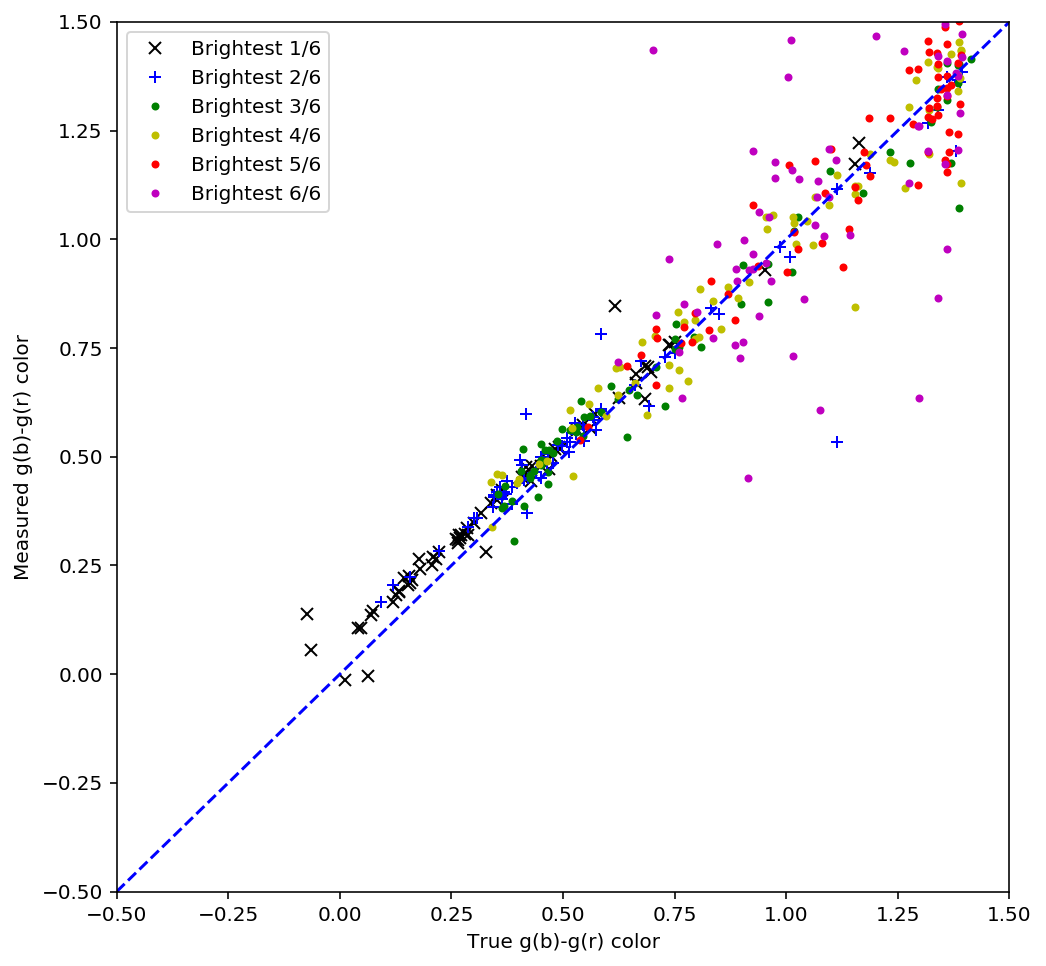

In [46]:
inds = np.argsort(sim_flux_sum)
ninds = len(inds) 
nbins = 6
sim_color = np.array(sim_color)
meas_color = np.array(meas_color)

inds_arr = [inds[(i*ninds)//nbins:((i + 1)*ninds)//nbins] for i in range(nbins)]
colors = ['m','r', 'y','g','b','k']
symbol = '.'*4 + '+' + 'x'
c_sym = [colors[i] + symbol[i] for i in range(nbins)]
fig=plt.figure(figsize=(8,8))
plot_1 = fig.add_subplot(1,1,1)
slope_correction = 1.
offset = 0.
for i in range(6):
    i_use = 5-i
    plot_1.plot(sim_color[inds_arr[i_use]], meas_color[inds_arr[i_use]]*slope_correction+offset, c_sym[i_use])
plot_1.plot([-.5, 1.5], [-.5, 1.5], linestyle='--', color='b')
plot_1.set_ylabel('Measured g(b)-g(r) color')
plot_1.set_xlabel('True g(b)-g(r) color')
plot_1.set_xlim([-.5, 1.5])
plot_1.set_ylim([-.5, 1.5])
plot_1.legend(["Brightest 1/6",
               "Brightest 2/6",
               "Brightest 3/6",
               "Brightest 4/6",
               "Brightest 5/6",
               "Brightest 6/6",])